<center style='color:red'><h2>Skin Disease Classification</h2><h2>Ecole Polytechnique de Thiès</center>

<h4>DIC2 Genie Informatique et télécommunications</h4>
<h4>Année: 2022-2023</h4>
<h4>Professeurs: Dr. Michel Seck & Dr. Ndeye Fatou Ngom</h4>
<h4 style="text-align:right">Par: Mohamed Massamba Sene</h4>

![image](https://i.ibb.co/QJ4MF3B/Skin-Disease.png)

# Plan

## Segmentation
     
1. [Import des modules](#title-1)
2. [Chargement des données](#title-2)
3. [Prétraitement des données](#title-3)
4. [Architecture du modèle](#title-4)
5. [Entrainement du modèle](#title-5)
6. [Visualisation et Prédiction](#title-6)
    
## Classification
    
7. [Prétraitment des données](#title-7)
8. [Architecture du modèle](#title-8)
9. [Entrainement du modèle](#title-9)
10. [Visualisation et Prédiction](#title-10)
    
## Pipeline (Segmentation + Classification)
    
## Analyse des résultats
    
<hr/>

## <em>Partie 1: Segmentation<em>

### Import des modules <a id="title-1"></a>

In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
from keras import backend as K
from keras_tuner import RandomSearch
import warnings
from glob import glob
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report

### Chargement des données <a id="title-2"></a>

In [2]:
labels = {
    0: "Common Nevus",
    1: "Atypical Nevus",
    2: "Melanoma"
}

images = []
image_segmentations = []
image_labels = []

In [3]:
df = pd.read_csv("PH2Dataset/PH2_Dataset.csv")
df

Name  Clinical Diagnosis
0    IMD003                   0
1    IMD009                   0
2    IMD016                   0
3    IMD022                   0
4    IMD024                   0
..      ...                 ...
195  IMD424                   2
196  IMD425                   2
197  IMD426                   2
198  IMD429                   2
199  IMD435                   2

[200 rows x 2 columns]

In [4]:
BASE_DIR = "PH2Dataset/PH2 Dataset images/"
for folder in os.listdir(BASE_DIR):
    if folder != ".DS_Store":
        for image_folder in os.listdir(os.path.join(BASE_DIR, folder)):
            if "Dermoscopic_Image" in image_folder:
                images.append(cv2.cvtColor(cv2.imread(os.path.join(BASE_DIR, folder, image_folder, folder+".bmp")), cv2.COLOR_BGR2RGB))
            if "lesion" in image_folder:
                image_segmentations.append(cv2.cvtColor(cv2.imread(os.path.join(BASE_DIR, folder, image_folder, folder+"_lesion.bmp")), cv2.COLOR_BGR2GRAY))
        image_labels.append(float(df[df["Name"]==folder]["Clinical Diagnosis"].values[0]))

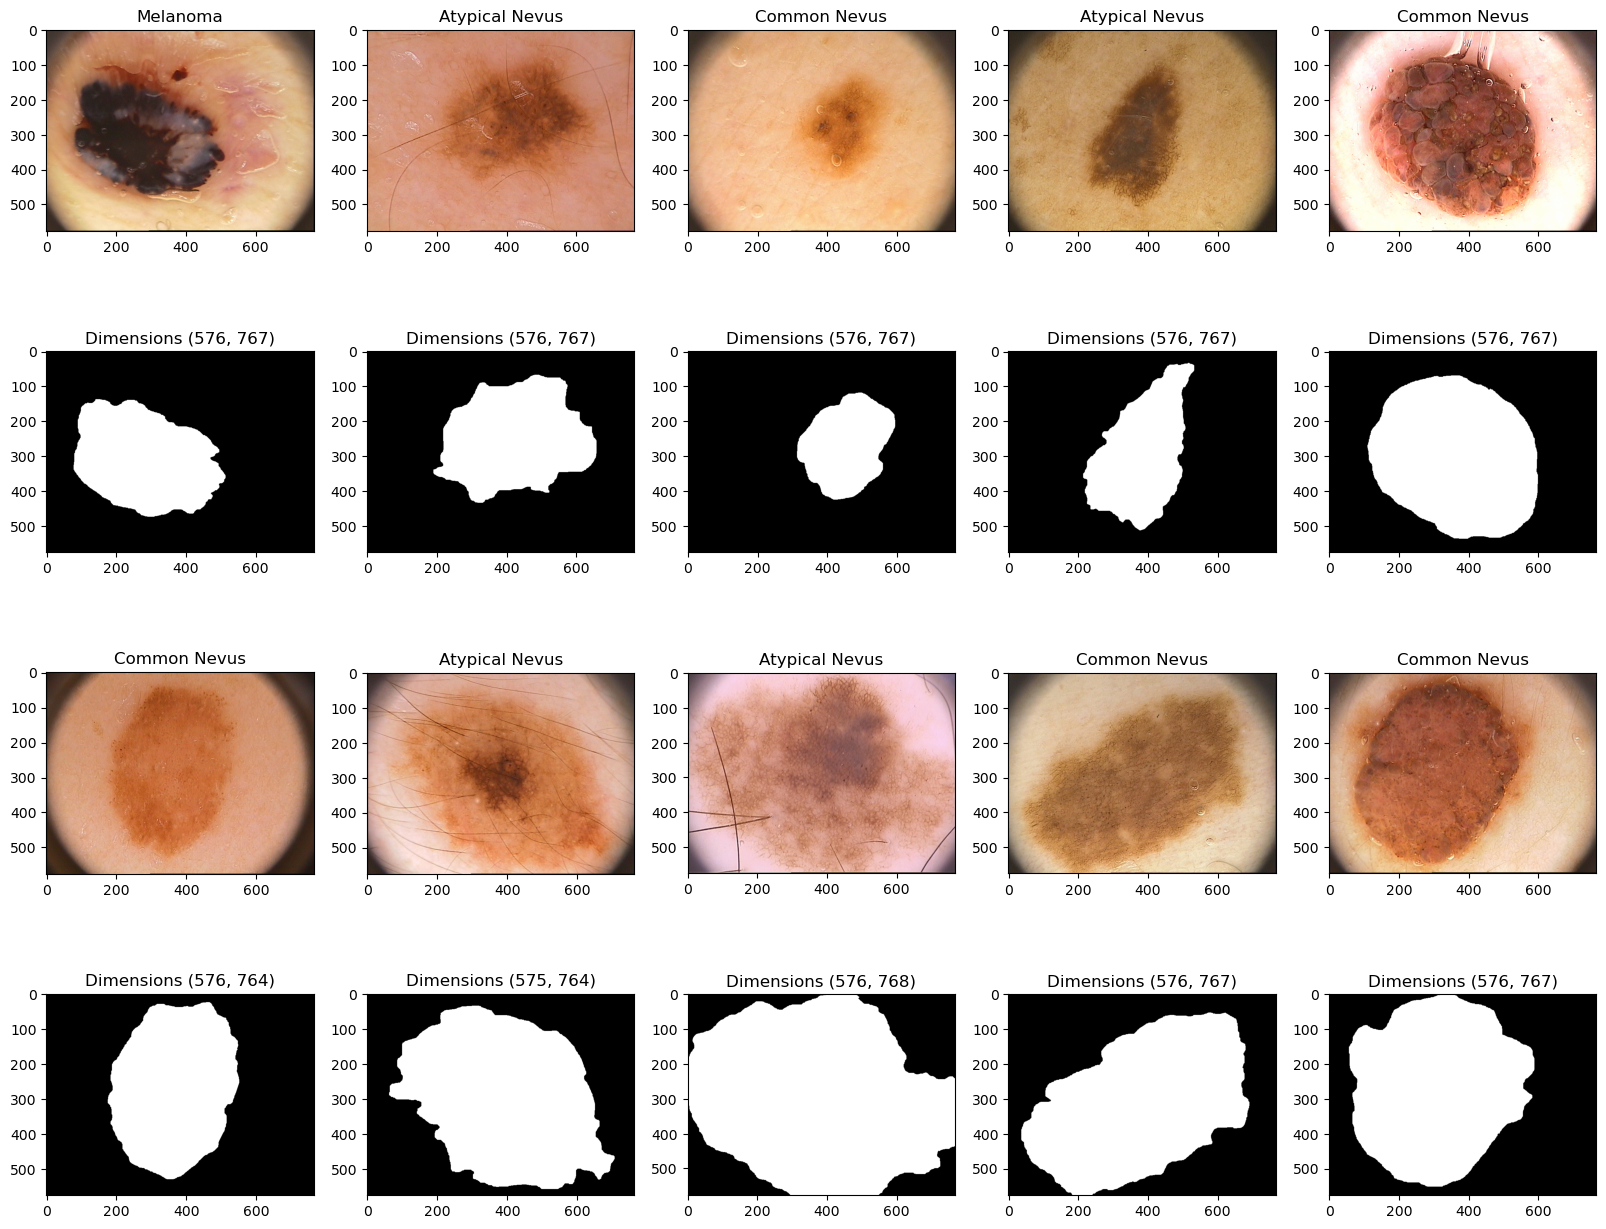

In [5]:
fig, axes = plt.subplots(4, 5, figsize=(20,16))

for j in range(5):
    axes[0,j].imshow(images[j])
    axes[1,j].imshow(image_segmentations[j], cmap="gray")
    axes[0,j].set_title(labels[image_labels[j]])
    axes[1,j].set_title("Dimensions "+ str(image_segmentations[j].shape))
    axes[2,j].imshow(images[j+5])
    axes[3,j].imshow(image_segmentations[j+5], cmap="gray")
    axes[2,j].set_title(labels[image_labels[j+5]])
    axes[3,j].set_title("Dimensions "+str(image_segmentations[j+5].shape))

plt.show()

### Prétraitement des images <a id="title-3"></a>

**Redimensionnement et Normalisation**

En visualisant les données, nous avons eu à constater que les images n'étaient pas toutes de même dimensions, il faut donc qu'on redimmensionne pour qu'elles puissent être passées au modèle

In [6]:
IMG_SIZE = (224, 224)

def resize(img, IMG_SIZE=IMG_SIZE):
    return cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)

images_resized = [resize(img) for img in images]
image_segmentations_resized = [resize(img_segmentation) for img_segmentation in image_segmentations]

images_resized = [img/255.0 for img in images_resized]
image_segmentations_resized = [img/255.0 for img in image_segmentations_resized]

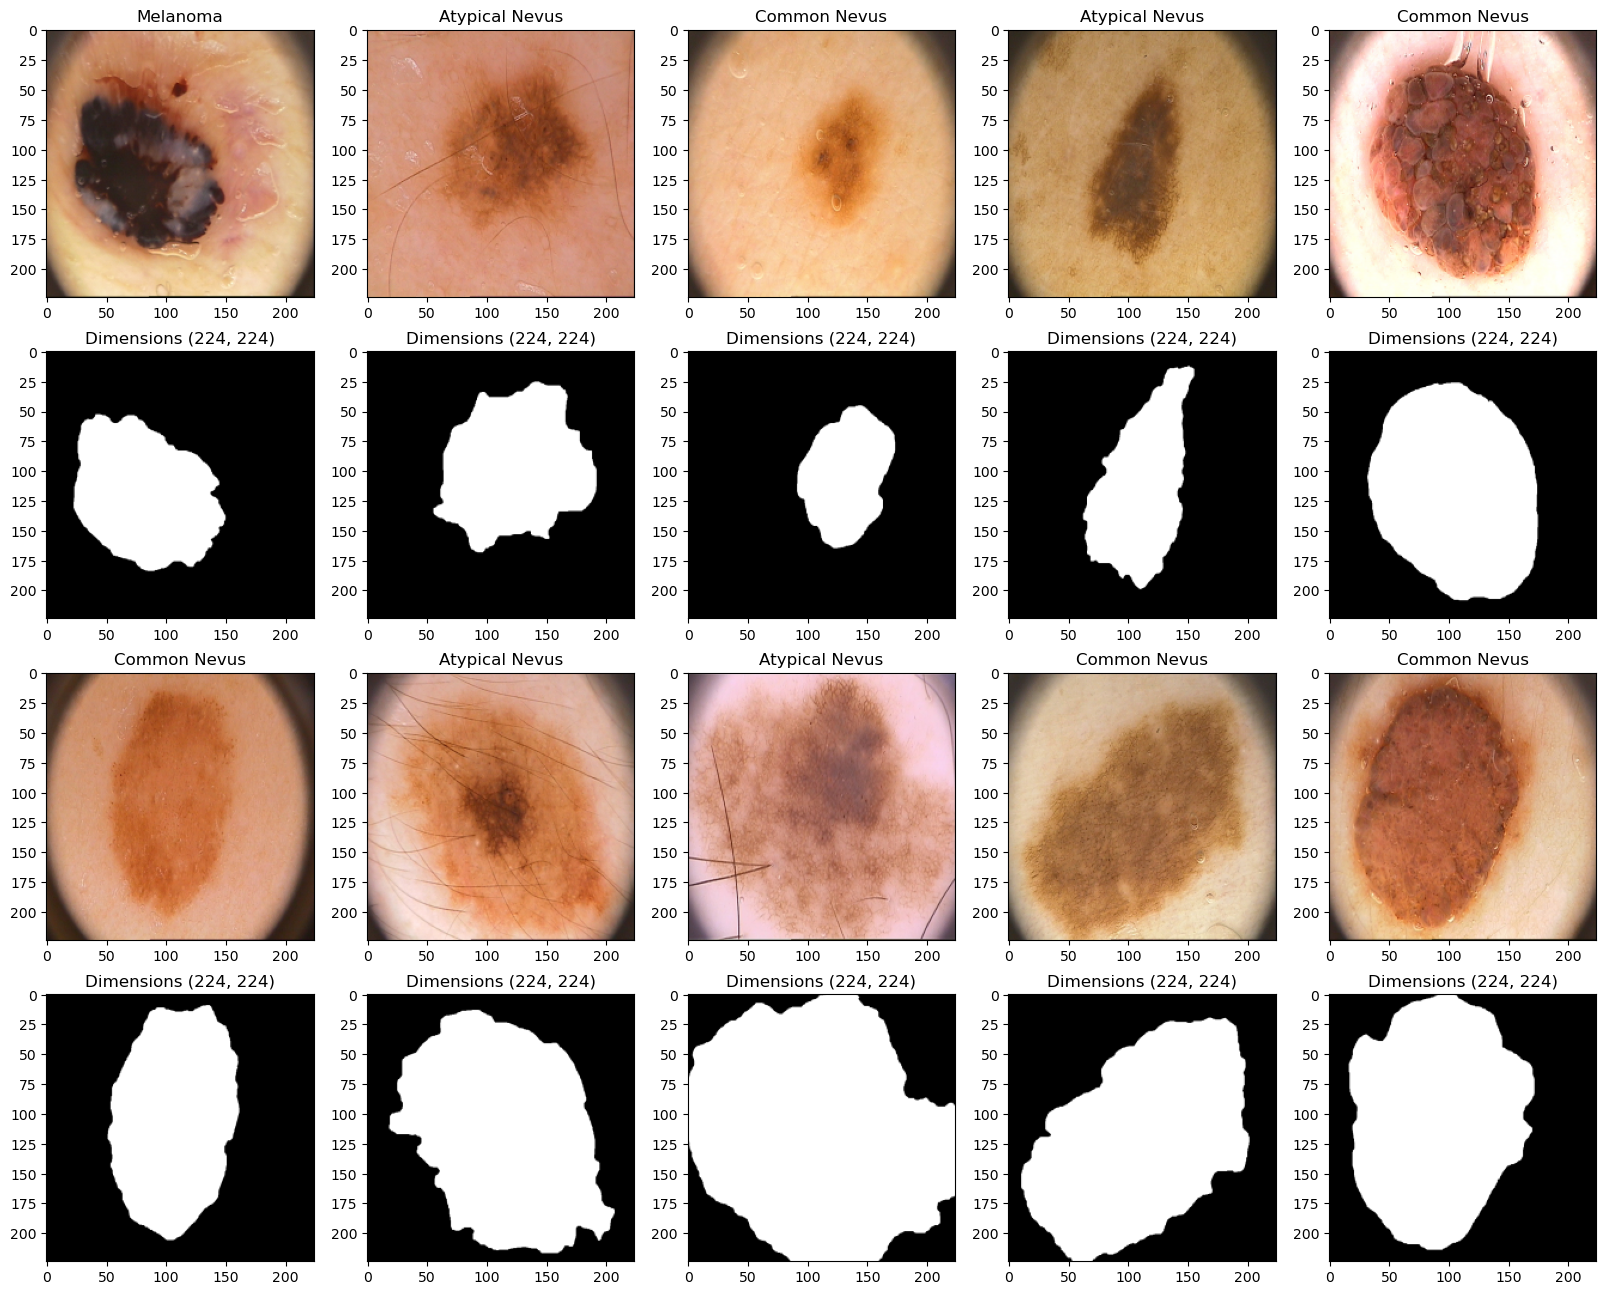

In [7]:
fig, axes = plt.subplots(4, 5, figsize=(20,16))

for j in range(5):
    axes[0,j].imshow(images_resized[j])
    axes[1,j].imshow(image_segmentations_resized[j], cmap="gray")
    axes[0,j].set_title(labels[image_labels[j]])
    axes[1,j].set_title("Dimensions "+ str(image_segmentations_resized[j].shape))
    axes[2,j].imshow(images_resized[j+5])
    axes[3,j].imshow(image_segmentations_resized[j+5], cmap="gray")
    axes[2,j].set_title(labels[image_labels[j+5]])
    axes[3,j].set_title("Dimensions "+str(image_segmentations_resized[j+5].shape))

plt.show()

**Splitting du jeu de données et Augmentation d'images**

Notre jeu de données étant composé d'un nombre relativement faible d'images (200), nous allons effectuer de l'augmentation d'images en appliquant de la rotation et du flipping à chaque image...

In [8]:
images_resized = np.array(images_resized)
image_segmentations_resized = np.array(image_segmentations_resized)
image_labels = np.array(image_labels)
X_train, X_test, Xseg_train, Xseg_test, y_train, y_test = train_test_split(images_resized, image_segmentations_resized, image_labels, test_size=.2)

In [9]:
X_train.shape, Xseg_train.shape, y_train.shape

((160, 224, 224, 3), (160, 224, 224), (160,))

In [10]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return np.array(x_image), np.array(y_image.astype('int'))

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [11]:
def img_augmentation(x_train, seg_train, y_train):
    x_rotat = []
    seg_rotat = []
    x_flip = []
    seg_flip = []
    rotated_images_labels = []
    flipped_images_labels = []
    for idx in range(len(x_train)):
        x,seg = random_rotation(x_train[idx], seg_train[idx])
        x_rotat.append(x)
        seg_rotat.append(seg)
        
        x,seg = horizontal_flip(x_train[idx], seg_train[idx])
        x_flip.append(x)
        seg_flip.append(seg)
        
        rotated_images_labels.append(y_train[idx])
        flipped_images_labels.append(y_train[idx])
        
    return np.array(x_rotat), np.array(seg_rotat), np.array(x_flip), np.array(seg_flip), np.array(rotated_images_labels), np.array(flipped_images_labels)

In [12]:
X_rotated, Xseg_rotated, X_flipped, Xseg_flipped, rotated_images_labels, flipped_images_labels = img_augmentation(X_train, Xseg_train, y_train)

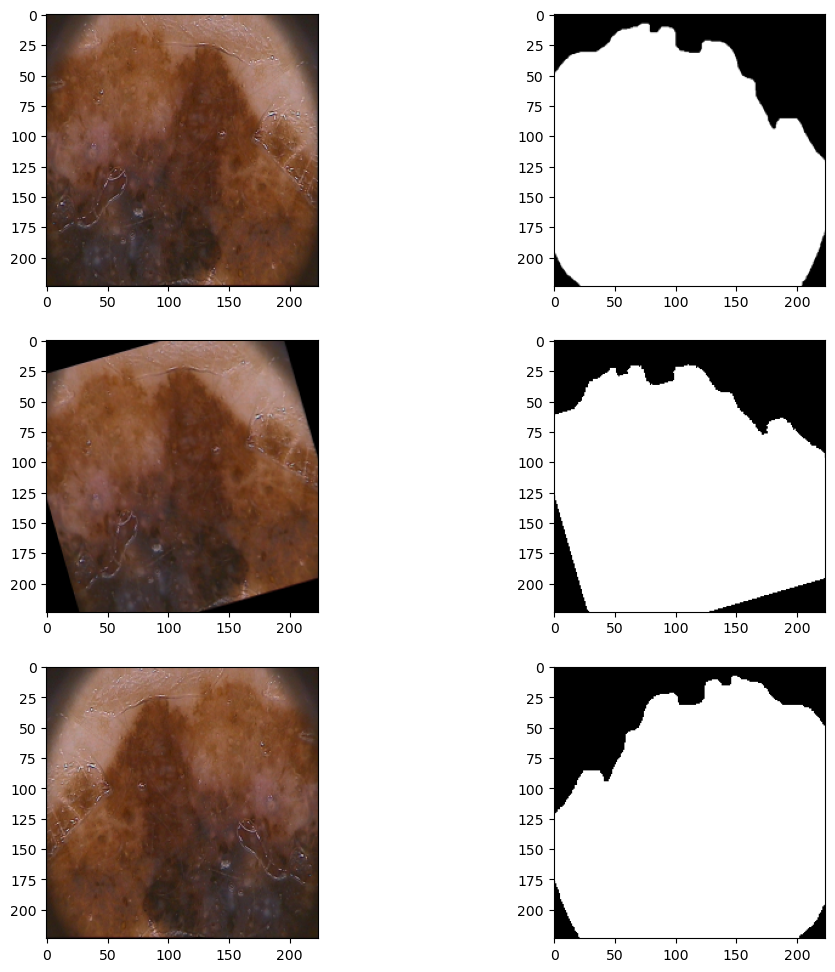

In [13]:
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(X_train[0])
plt.subplot(3,2,2)
plt.imshow(Xseg_train[0], cmap='gray')
plt.subplot(3,2,3)
plt.imshow(X_rotated[0])
plt.subplot(3,2,4)
plt.imshow(Xseg_rotated[0], cmap='gray')
plt.subplot(3,2,5)
plt.imshow(X_flipped[0])
plt.subplot(3,2,6)
plt.imshow(Xseg_flipped[0], cmap='gray')
plt.show()

In [14]:
X_train = np.concatenate([X_train, X_rotated, X_flipped])
Xseg_train = np.concatenate([Xseg_train, Xseg_rotated, Xseg_flipped])
y_train = np.concatenate([y_train, rotated_images_labels, flipped_images_labels])

**Ensemble de validation**

In [15]:
X_train, X_val, seg_train, seg_val = train_test_split(X_train, Xseg_train, test_size = 0.20)

print("Taille du Training Set   : {}".format(len(X_train)))
print("Taille du Test Set       : {}".format(len(X_test)))
print("Taille du Validation Set : {}".format(len(X_val)))

Taille du Training Set   : 384
Taille du Test Set       : 40
Taille du Validation Set : 96


### Architecture du modèle <a id="title-4"></a>

Pour le modèle, nous utilisons U-net qui est un modèle de segmentation pour les images biomédicales.

![img](https://i.ibb.co/vXyvB5Z/Architecture.png)

**Fonction coût**

> Jaccard Distance

La distance de Jaccard, également appelée indice de similarité de Jaccard, est une mesure de similarité entre deux ensembles. Elle est souvent utilisée pour évaluer la similarité entre deux ensembles de données:

$JaccardIndex = \frac{|A\cap B|}{|A \cup B|} = \frac{|A \cap B|}{|A|+|B|-|A \cap B|}$

$JaccardDistance = 1 - JaccardIndex$

Dans le contexte du traitement d'images et de la segmentation d'images, la distance de Jaccard peut être utilisée comme fonction de coût pour mesurer la similarité entre le masque de segmentation prédit par un modèle et le masque de segmentation réel (ground truth). Plus précisément, la distance de Jaccard peut être utilisée pour évaluer la superposition ou la correspondance entre les pixels prédits et les pixels réels dans les masques de segmentation.


In [6]:
def jaccard_distance(y_true, y_pred, smooth=100):
    y_true = tf.cast(y_true, tf.float32)
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

**Métriques**

On utilise également IoU (Intersect over Union) comme métrique d'évaluation pour les tâches de segmentation d'images. Elle permet de quantifier la similarité entre les masques de segmentation prédits et ceux réels.

In [7]:
def iou(y_true, y_pred, smooth = 100):
    y_true = tf.cast(y_true, tf.float32)
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [8]:
def precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [9]:
def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [10]:
def accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return K.mean(K.equal(y_true, K.round(y_pred)))

**Définir le modèle**

In [12]:
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 1

def double_conv_layer(x, size, dropout=0.4, batch_norm=True):
    if K.image_data_format() == 'th':
        axis = 1
    else:
        axis = 3
    conv = keras.layers.Conv2D(size, (3,3), padding='same')(x)
    if batch_norm is True:
        conv = keras.layers.BatchNormalization(axis=axis)(conv)
    conv = keras.layers.Activation('relu')(conv)
    conv = keras.layers.Conv2D(size, (3,3), padding='same')(conv)
    if batch_norm is True:
        conv = keras.layers.BatchNormalization(axis=axis)(conv)
    conv = keras.layers.Activation('relu')(conv)
    if dropout > 0:
        conv = keras.layers.SpatialDropout2D(dropout)(conv)
    return conv

def UNET(x_train, y_train, x_val, y_val, epochs, filename):
    dropout_val = 0.5
    if K.image_data_format() == 'th':
        inputs = keras.layers.Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = keras.layers.Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32
    
    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_224)
    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_112)
    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_56)
    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_28)
    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_14)
    conv_7 = double_conv_layer(pool_7, 32*filters)
    up_14 = keras.layers.concatenate([keras.layers.UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)
    up_28 = keras.layers.concatenate([keras.layers.UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)
    up_56 = keras.layers.concatenate([keras.layers.UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)
    up_112 = keras.layers.concatenate([keras.layers.UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)
    up_224 = keras.layers.concatenate([keras.layers.UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = keras.layers.Conv2D(OUTPUT_CHANNELS, (1, 1))(up_conv_224)
    conv_final = keras.layers.Activation('sigmoid')(conv_final)
    pred = keras.layers.Reshape((224,224))(conv_final)
    model = keras.Model(inputs, pred, name="UNET_28")
    model.compile(optimizer= keras.optimizers.Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs, batch_size= 18,validation_data=(x_val, y_val), verbose=1)
    model.save(filename)
    return model, hist

### Entrainement du modèle <a id="title-5"></a>

In [22]:
# model, hist = UNET(X_train, seg_train, X_val, seg_val, 100, 'unet28_100_epoch.h5')

Metal device set to: Apple M2 Pro


Model: "UNET_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

2023-09-08 22:00:50.102284: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


22/22 [==============================] - 21s 846ms/step - loss: 0.1576 - iou: 0.8424 - precision: 0.7054 - recall: 0.7157 - accuracy: 0.8088 - val_loss: 0.2741 - val_iou: 0.7259 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.6753
Epoch 2/100
22/22 [==============================] - 17s 767ms/step - loss: 0.1087 - iou: 0.8913 - precision: 0.8247 - recall: 0.7694 - accuracy: 0.8779 - val_loss: 0.2527 - val_iou: 0.7473 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.6753
Epoch 3/100
22/22 [==============================] - 16s 752ms/step - loss: 0.0948 - iou: 0.9052 - precision: 0.8483 - recall: 0.7824 - accuracy: 0.8903 - val_loss: 0.2459 - val_iou: 0.7541 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.6753
Epoch 4/100
22/22 [==============================] - 16s 739ms/step - loss: 0.0909 - iou: 0.9091 - precision: 0.8721 - recall: 0.7828 - accuracy: 0.8981 - val_loss: 0.2285 - val_iou: 0.7715 - val_precision: 0.6168 

In [13]:
dropout_val=0.50
if K.image_data_format() == 'th':
    inputs = keras.layers.Input((INPUT_CHANNELS, 224, 224))
    axis = 1
else:
    inputs = keras.layers.Input((224, 224, INPUT_CHANNELS))
    axis = 3
filters = 32

conv_224 = double_conv_layer(inputs, filters)
pool_112 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_224)
conv_112 = double_conv_layer(pool_112, 2*filters)
pool_56 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_112)
conv_56 = double_conv_layer(pool_56, 4*filters)
pool_28 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_56)
conv_28 = double_conv_layer(pool_28, 8*filters)
pool_14 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_28)
conv_14 = double_conv_layer(pool_14, 16*filters)
pool_7 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_14)
conv_7 = double_conv_layer(pool_7, 32*filters)
up_14 = keras.layers.concatenate([keras.layers.UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
up_conv_14 = double_conv_layer(up_14, 16*filters)
up_28 = keras.layers.concatenate([keras.layers.UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
up_conv_28 = double_conv_layer(up_28, 8*filters)
up_56 = keras.layers.concatenate([keras.layers.UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
up_conv_56 = double_conv_layer(up_56, 4*filters)
up_112 = keras.layers.concatenate([keras.layers.UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
up_conv_112 = double_conv_layer(up_112, 2*filters)
up_224 = keras.layers.concatenate([keras.layers.UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

conv_final = keras.layers.Conv2D(OUTPUT_CHANNELS, (1, 1))(up_conv_224)
conv_final = keras.layers.Activation('sigmoid')(conv_final)
pred = keras.layers.Reshape((224,224))(conv_final)

Metal device set to: Apple M2 Pro


In [14]:
model_1 = keras.models.Model(inputs, pred, name="UNET")
model_1.compile(optimizer= keras.optimizers.legacy.Adam(learning_rate = 0.003), loss= [jaccard_distance],metrics=[iou, precision, recall, accuracy])
model_1.load_weights('unet_100_epoch.h5')

In [25]:
res = model_1.evaluate(X_test, Xseg_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Precision: |   {:.2f}  |'.format(res[2]*100))
print('Recall:    |   {:.2f}  |'.format(res[3]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[4]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')

3/3 [==============================] - 1s 238ms/step - loss: 0.0467 - iou: 0.9533 - precision: 0.9128 - recall: 0.9450 - accuracy: 0.9410
________________________
IOU:       |   95.33  |
Precision: |   91.28  |
Recall:    |   94.50  |
Accuracy:  |   94.10  |
Loss:      |   4.67  |
________________________


### Visualisation et Prédictions <a id="title-6"></a>

In [27]:
def enhance(img):
    sub = img.flatten()
    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub.reshape(224,224,1)

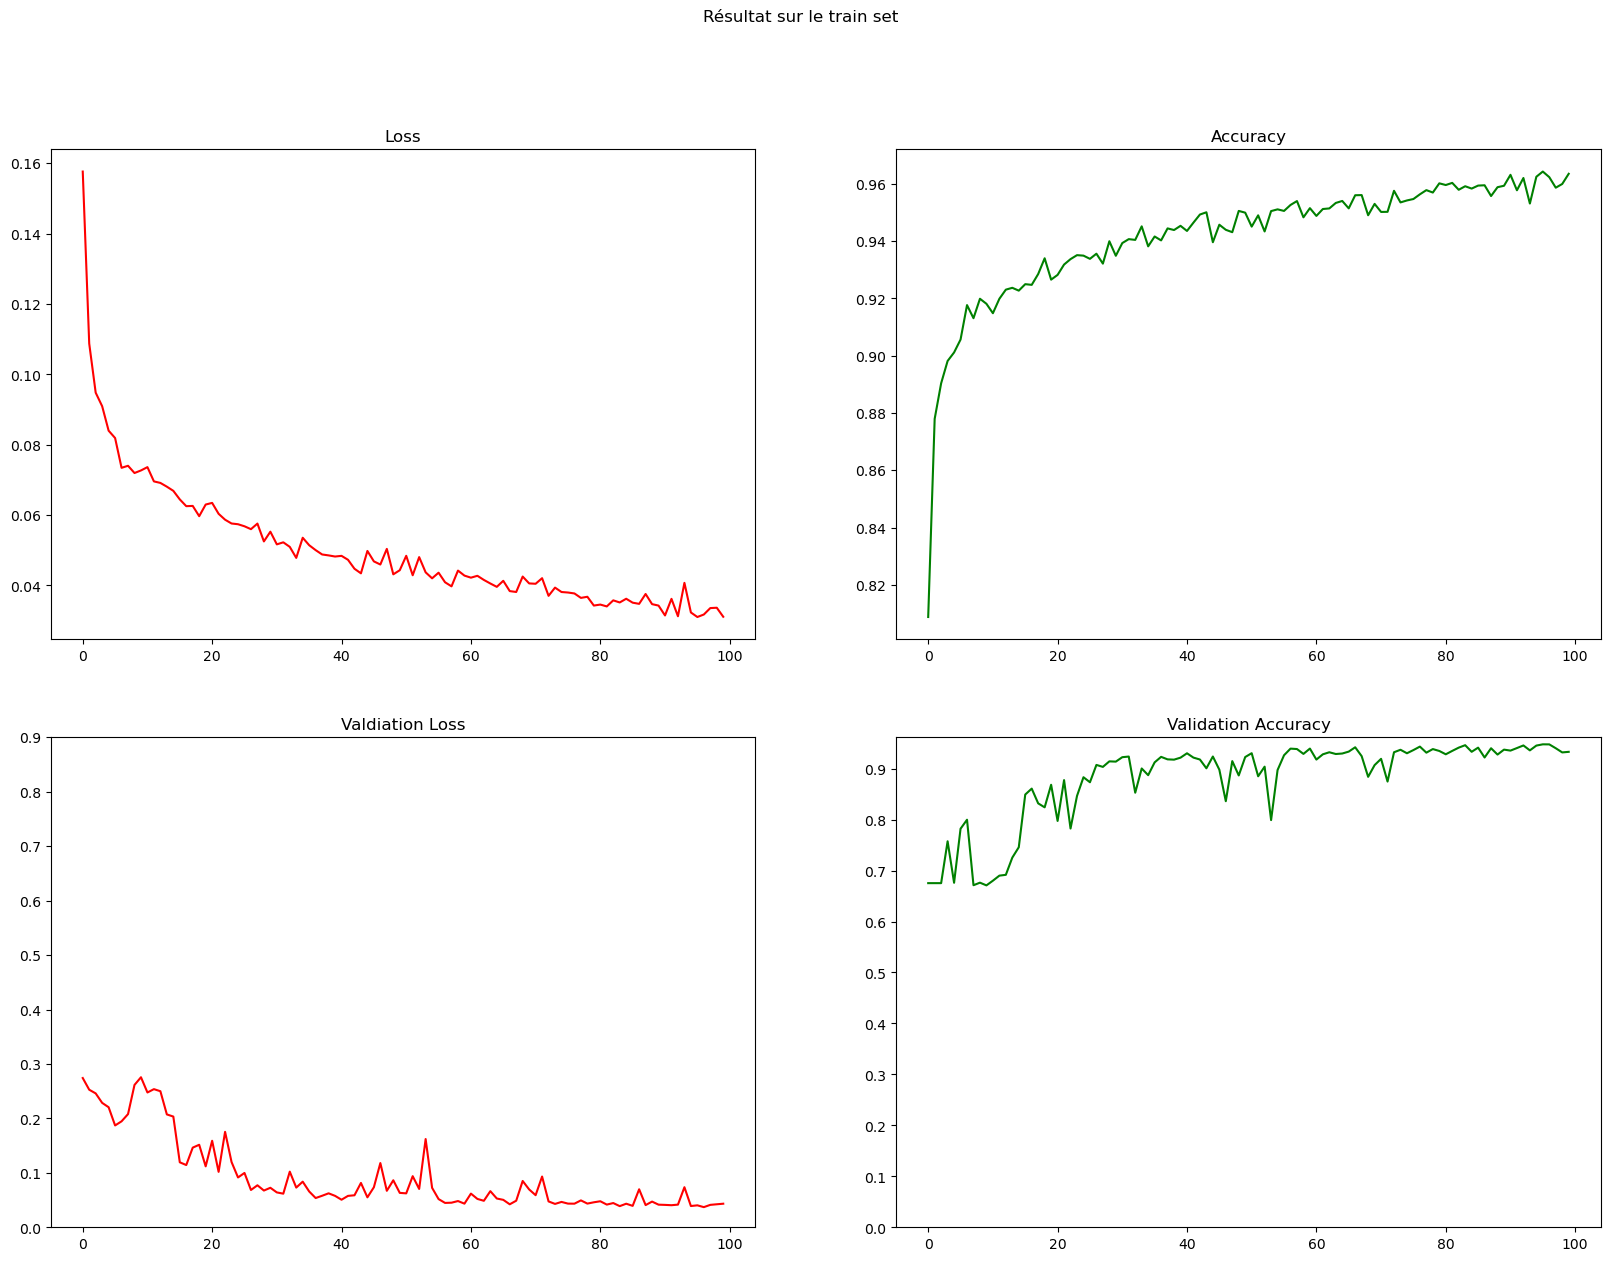

In [26]:
plt.figure(figsize=(20, 14))
plt.suptitle('Résultat sur le train set')
plt.subplot(2,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

1/1 [==============================] - 0s 27ms/step


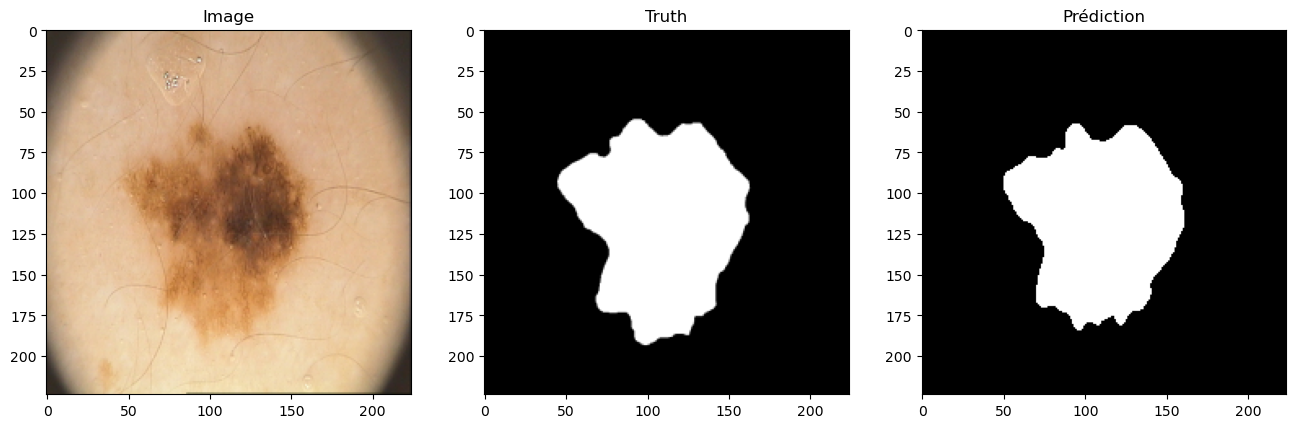

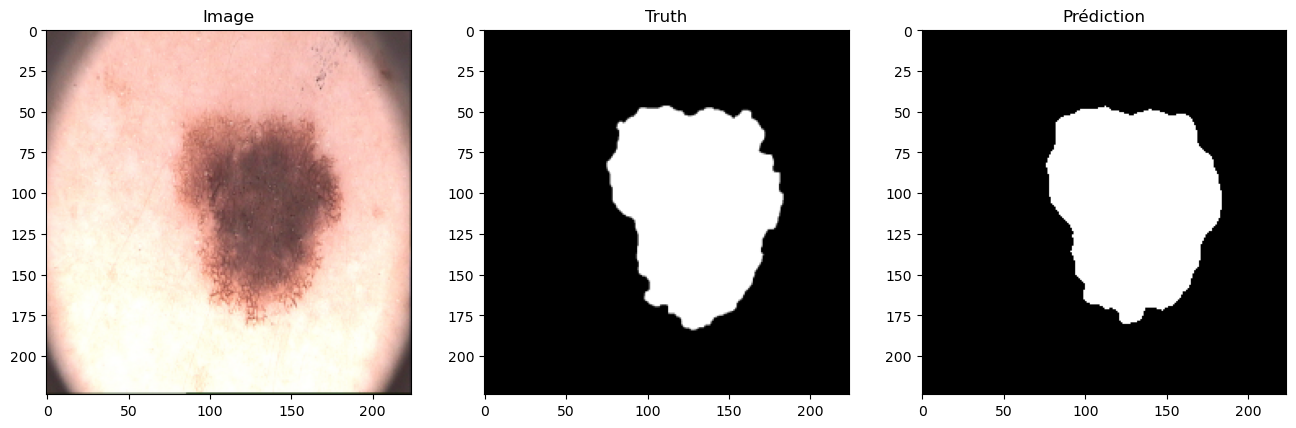

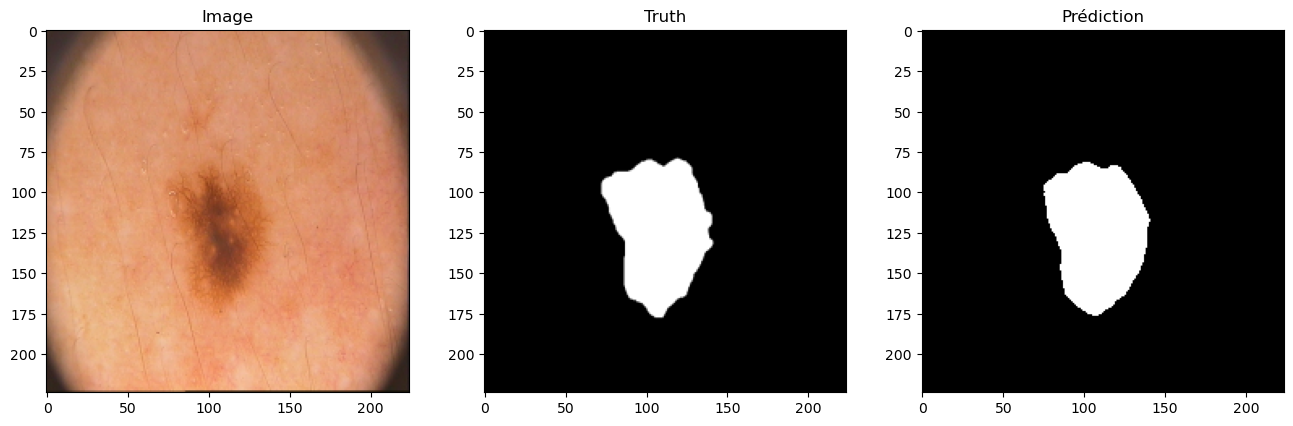

In [28]:
for i in range(1,4):
    img_pred = model_1.predict(X_test[i].reshape(1,224,224,3))
    plt.figure(figsize=(16,16))
    plt.subplot(i,3,1)
    plt.imshow(X_test[i])
    plt.title('Image')
    plt.subplot(i,3,2)
    plt.imshow(Xseg_test[i], cmap='gray')
    plt.title('Truth')
    plt.subplot(i,3,3)
    plt.imshow(enhance(img_pred), cmap='gray')
    plt.title('Prédiction')
    
plt.show()

## <em>Partie 2: Classification</em>

Nous pouvons donc faire les constats suivant:
- Les classes comme Dermatofibroma et Vascular lesions sont très peu représenté, nous allons donc tenter de les regrouper sous une seule classes autres qui sera utilisée
- La classe Melanocytic nevi est largment représentée avec près de 7000 images ce qui conduit à un déséquilibre, nous allons donc effectuer du downsampling à ce niveau

### Prétraitement des données <a id="title-7"></a>

Nous allons utiliser le jeu de données HAMM_1000 pour la classification, il contient plus de 10000 images de 7 classes

In [2]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

skin_df = pd.read_csv("PH2Dataset/HAM10000_metadata.csv")
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [3]:
skin_df

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                            cell_type  cell_type_idx  
0      Benign keratosis-like lesions               2  
1      Benign keratosis-like lesions               2  
2      Benign keratosis-like lesions               2  
3      Benign keratosis-like lesions               2  
4      Benign keratosis-like lesions               2  
...                               ...            ...  
10010               Actinic keratoses              0  
10011               Actinic keratoses              0  
10012               Actinic keratoses              0  
10013               Actinic keratoses              0  
10014                        Melanoma              5  

[10015 rows x 9 columns]

In [4]:
df_no_dup = skin_df.groupby('lesion_id').count()
df_no_dup = df_no_dup[df_no_dup['image_id']==1]
df_no_dup.reset_index(inplace=True)
df_no_dup.head()

lesion_id  image_id  dx  dx_type  age  sex  localization  cell_type  \
0  HAM_0000001         1   1        1    1    1             1          1   
1  HAM_0000003         1   1        1    1    1             1          1   
2  HAM_0000004         1   1        1    1    1             1          1   
3  HAM_0000007         1   1        1    1    1             1          1   
4  HAM_0000008         1   1        1    1    1             1          1   

   cell_type_idx  
0              1  
1              1  
2              1  
3              1  
4              1

In [5]:
def get_duplicates(x):
    unique_list = list(df_no_dup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

skin_df['duplicates'] = skin_df['lesion_id']
skin_df['duplicates'] = skin_df['duplicates'].apply(get_duplicates)
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                        cell_type  cell_type_idx  duplicates  
0  Benign keratosis-like lesions               2  duplicated  
1  Benign keratosis-like lesions               2  duplicated  
2  Benign keratosis-like lesions               2  duplicated  
3  Benign keratosis-like lesions               2  duplicated  
4  Benign keratosis-like lesions               2  duplicated

In [15]:
skin_df['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [16]:
df_no_dup = skin_df[skin_df['duplicates'] == 'unduplicated']
df_no_dup.head()

lesion_id      image_id   dx dx_type   age     sex localization  \
10  HAM_0001396  ISIC_0025276  bkl   histo  55.0  female        trunk   
15  HAM_0007207  ISIC_0031326  bkl   histo  65.0    male         back   
20  HAM_0006071  ISIC_0032343  bkl   histo  70.0  female         face   
33  HAM_0005612  ISIC_0024981  bkl   histo  80.0    male        scalp   
34  HAM_0005388  ISIC_0027815  bkl   histo  80.0    male        chest   

                         cell_type  cell_type_idx    duplicates  
10  Benign keratosis-like lesions               2  unduplicated  
15  Benign keratosis-like lesions               2  unduplicated  
20  Benign keratosis-like lesions               2  unduplicated  
33  Benign keratosis-like lesions               2  unduplicated  
34  Benign keratosis-like lesions               2  unduplicated

In [17]:
y = df_no_dup['cell_type_idx']
_, df_val = train_test_split(df_no_dup, test_size=0.2, random_state=101, stratify=y)
df_val.head()

lesion_id      image_id     dx    dx_type   age     sex  \
4781  HAM_0000199  ISIC_0026127     nv  follow_up  55.0    male   
3294  HAM_0006655  ISIC_0025994     nv  follow_up  50.0  female   
1421  HAM_0002897  ISIC_0030552    mel      histo  75.0    male   
9816  HAM_0004563  ISIC_0031211  akiec      histo  75.0    male   
8611  HAM_0004275  ISIC_0026921     nv      histo  70.0  female   

         localization          cell_type  cell_type_idx    duplicates  
4781  lower extremity   Melanocytic nevi              4  unduplicated  
3294  lower extremity   Melanocytic nevi              4  unduplicated  
1421             back           Melanoma              5  unduplicated  
9816  lower extremity  Actinic keratoses              0  unduplicated  
8611             back   Melanocytic nevi              4  unduplicated

In [18]:
df_val['cell_type_idx'].value_counts()

4    883
2     88
5     46
1     35
0     30
6     13
3      8
Name: cell_type_idx, dtype: int64

In [19]:
def get_val_rows(x):
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

skin_df['train_or_val'] = skin_df['image_id']
skin_df['train_or_val'] = skin_df['train_or_val'].apply(get_val_rows)
df_train = skin_df[skin_df['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [20]:
df_train['cell_type_idx'].value_counts()

4    5822
5    1067
2    1011
1     479
0     297
6     129
3     107
Name: cell_type_idx, dtype: int64

In [21]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  883
Benign keratosis-like lesions      88
Melanoma                           46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: cell_type, dtype: int64

In [22]:
data_aug_rate = [15,10,5,50,0,5,40]
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_train['cell_type'].value_counts()

/var/folders/j6/y8kx6d653d77lgg35197v5x00000gn/T/ipykernel_13640/3182111157.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)


Melanocytic nevi                  5822
Dermatofibroma                    5350
Melanoma                          5335
Vascular lesions                  5160
Benign keratosis-like lesions     5055
Basal cell carcinoma              4790
Actinic keratoses                 4455
Name: cell_type, dtype: int64

In [23]:
df_train, df_test = train_test_split(df_train, test_size=.1)

df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)
df_val.reset_index(inplace=True)

**Chargement des images/ Création du jeu de données**

In [24]:
def create_dataset(df):
    images = []
    labels = []
    for image_id in df['image_id'].values:
        img = cv2.cvtColor(cv2.imread(os.path.join("PH2Dataset/HAM10000_images", image_id+'.jpg')),cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224),interpolation=cv2.INTER_AREA)
        img = np.array(img, dtype='float32')
        img /= 255
        images.append(img)
        labels.append(df.loc[df['image_id']==image_id]['cell_type_idx'].values[0])
    return np.array(images), np.array(labels)

In [48]:
X_train, y_train = create_dataset(df_train)
y_train = to_categorical(y_train)

In [49]:
X_test, y_test = create_dataset(df_test)
y_test = to_categorical(y_test)

In [25]:
X_val, y_val = create_dataset(df_val)
y_val = to_categorical(y_val)

In [51]:
masks_train = []
prev = 0

for i in range(3237,32371,3237):
    masks = model_1.predict(X_train[prev:i],verbose=0)
    masks_train.append(masks)
    prev = i

enhanced_masks = []
for masks in masks_train:
    for mask in masks:
        enhanced_masks.append(enhance(mask))

masks_train = np.array(enhanced_masks)

In [28]:
masks = model_1.predict(X_val,verbose=0)
enhanced_masks = []
for mask in masks:
    enhanced_masks.append(enhance(mask))
masks_val = np.array(enhanced_masks)

In [53]:
masks = model_1.predict(X_test,verbose=0)
enhanced_masks = []
for mask in masks:
    enhanced_masks.append(enhance(mask))
masks_test = np.array(enhanced_masks)

In [54]:
X_train = np.concatenate((masks_train, masks_train, masks_train),axis=3)
masks_train = []
X_test = np.concatenate((masks_test, masks_test, masks_test),axis=3)
masks_test = []
X_val = np.concatenate((masks_val, masks_val, masks_val),axis=3)
masks_val = []
masks = []
enhanced_masks = []

In [55]:
print("Dimensions du Training Set   : {}".format(X_train.shape))
print("Dimensions du Test Set       : {}".format(X_test.shape))
print("Dimensions du Validation Set       : {}".format(X_val.shape))

Dimensions du Training Set   : (32370, 224, 224, 3)
Dimensions du Test Set       : (3597, 224, 224, 3)
Dimensions du Validation Set       : (1103, 224, 224, 3)


### Architecture du modèle <a id='title-8'></a>

![img](https://i.ibb.co/k5ZVXRQ/model.jpg)

In [61]:
def build_model(hp):
    model = keras.models.Sequential()
    
    model.add(keras.layers.Input(shape=[224, 224, 3]))
    model.add(keras.layers.Conv2D(hp.Int("units_1",16,32,step=16,default=32), (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.MaxPooling2D())
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(hp.Int("units_2",32,64,step=32,default=64), (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.Conv2D(hp.Int("units_2",32,64,step=32,default=64), (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.MaxPooling2D())
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(hp.Int("units_3",64,128,step=64,default=128), (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.Conv2D(hp.Int("units_3",64,128,step=64,default=128), (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.MaxPooling2D())
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(hp.Int("units_4",128,256,step=128,default=256), (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.Conv2D(hp.Int("units_4",128,256,step=128,default=256), (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.MaxPooling2D())
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(rate=hp.Float("rate",0.2,0.5,step=.1,default=0.2)))
    model.add(keras.layers.Dense(hp.Int("units_5",128,256,step=128,default=256), activation='relu', kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Dense(hp.Int("units_6",64,128,step=64,default=128), activation='relu', kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Dense(hp.Int("units_7",32,64,step=32,default=64), activation='relu', kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Dense(hp.Int("units_8",16,32,step=16,default=32), activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2()))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
    return model

tuner = RandomSearch(
        build_model,
        objective = "val_accuracy",
        max_trials = 5,
        executions_per_trial = 1
)

stop_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)
lr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=2,factor=0.5,min_lr=0.00001)

In [62]:
with tf.device("CPU"):
    train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(4*128).batch(128)
    validate = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(128)

### Entrainement du modèle <a id='title-9'></a>

In [63]:
tuner.search(
    train,
    validation_data= validate,
    epochs=5,
    callbacks=[stop_callback, lr_callback]
)

Trial 5 Complete [00h 04m 29s]
val_accuracy: 0.8005439639091492

Best val_accuracy So Far: 0.8014506101608276
Total elapsed time: 00h 24m 45s
INFO:tensorflow:Oracle triggered exit


In [72]:
models = tuner.get_best_models(num_models=1)
model = models[0]
history = model.fit(
    train,
    validation_data = validate,
    epochs=6,
    callbacks=[stop_callback, lr_callback]
)

Epoch 1/6
253/253 [==============================] - 108s 425ms/step - loss: 0.0221 - accuracy: 0.9944 - val_loss: 1.1875 - val_accuracy: 0.7960 - lr: 5.0000e-04
Epoch 2/6
253/253 [==============================] - 107s 424ms/step - loss: 0.0064 - accuracy: 0.9992 - val_loss: 1.2256 - val_accuracy: 0.7888 - lr: 5.0000e-04
Epoch 3/6
253/253 [==============================] - 107s 424ms/step - loss: 0.0030 - accuracy: 0.9999 - val_loss: 1.2613 - val_accuracy: 0.7960 - lr: 5.0000e-04
Epoch 4/6
253/253 [==============================] - 107s 425ms/step - loss: 0.0025 - accuracy: 0.9998 - val_loss: 1.2429 - val_accuracy: 0.7951 - lr: 2.5000e-04


In [78]:
# fig, axes = plt.subplots(2, 1, figsize=(20, 14))

# axes[0].plot(history.history['loss'], label='loss')
# axes[0].plot(history.history['val_loss'], label='val_loss')
# axes[0].set_title('Loss')

# axes[1].plot(history.history['accuracy'], label='accuracy')
# axes[1].plot(history.history['val_accuracy'], label='val_accuracy')
# axes[1].set_title('Accuracy')

# plt.legend()
# plt.show()

In [74]:
model.evaluate(X_test, y_test)

113/113 [==============================] - 4s 35ms/step - loss: 0.0652 - accuracy: 0.9808


[0.06516091525554657, 0.9808173775672913]

### Visualisation et prédictions

In [77]:
def print_confusion_matrix(confusion_matrix,class_names,figsize=(10,7),fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix,index=class_names,columns=class_names,)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm,annot=True,fmt='d')
    except ValueError:
        raise ValueError("Confusion matrix must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),rotation=0,ha="right",fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),rotation=45,ha="right",fontsize=fontsize)
    plt.ylabel("Truth")
    plt.xlabel("Prediction")

In [79]:
predictions = model.predict(X_test)
prediction_labels = np.argmax(predictions,1)

113/113 [==============================] - 4s 33ms/step


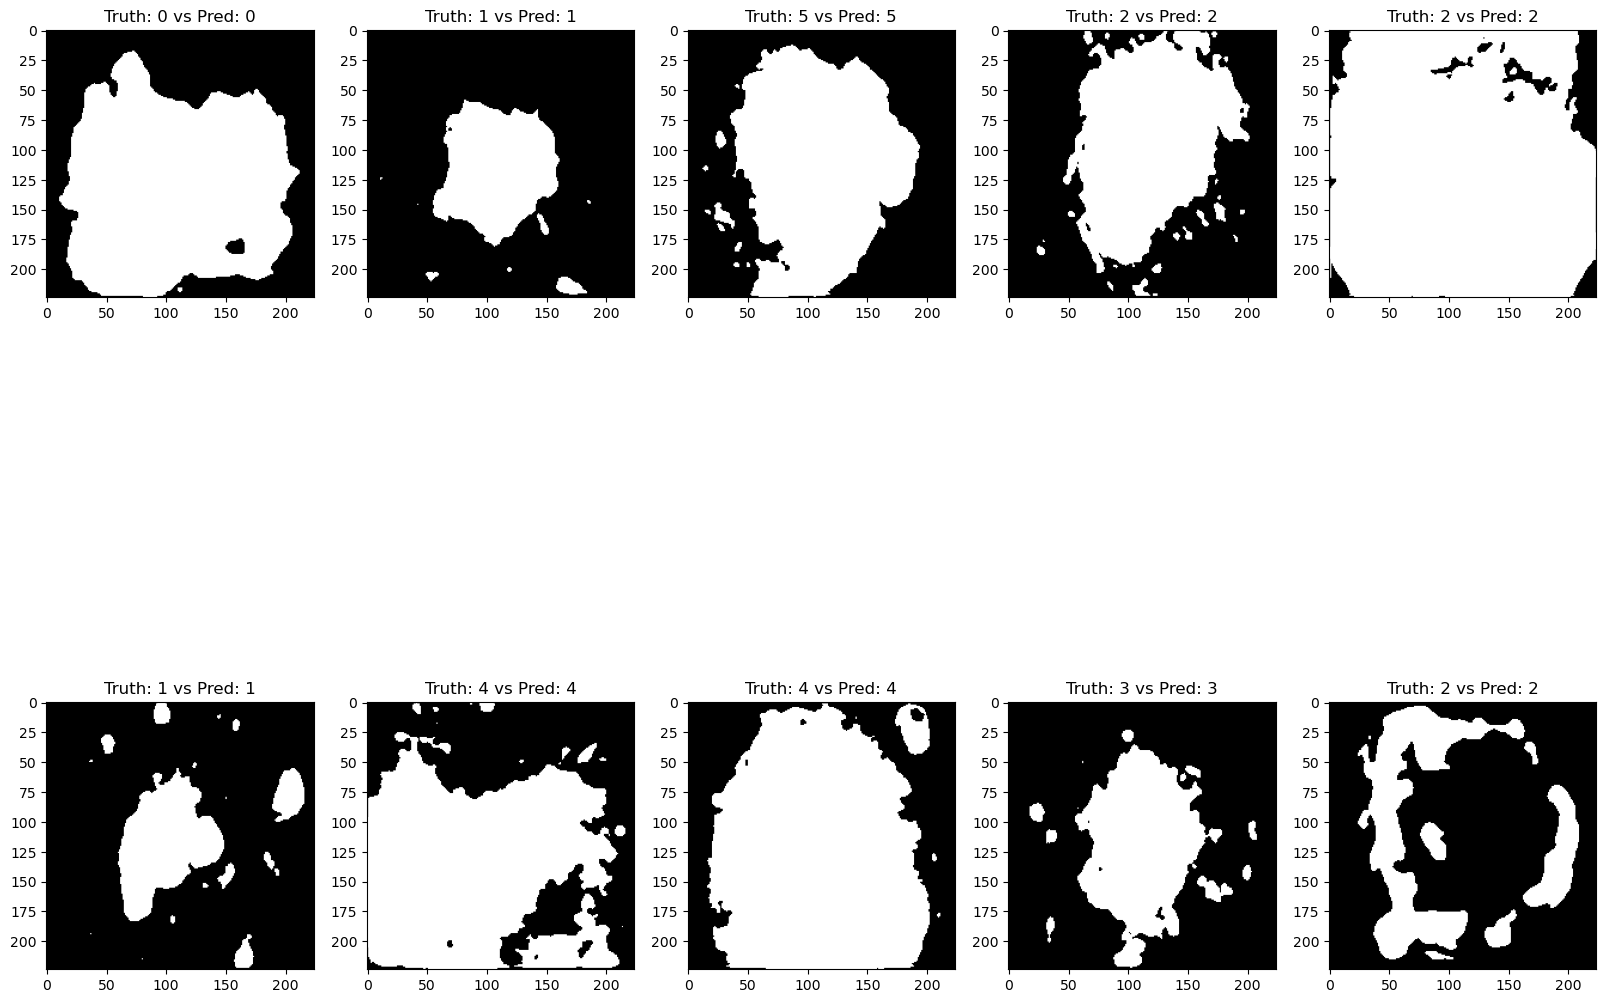

In [80]:
fig, axes = plt.subplots(2, 5, figsize=(20,16))

for j in range(5):
    axes[0,j].imshow(X_test[j])
    axes[1,j].imshow(X_test[j+5], cmap="gray")
    axes[0,j].set_title(f"Truth: {np.argmax(y_test[j])} vs Pred: {prediction_labels[j]}")
    axes[1,j].set_title(f"Truth: {np.argmax(y_test[j+5])} vs Pred: {prediction_labels[j+5]}")

plt.show()

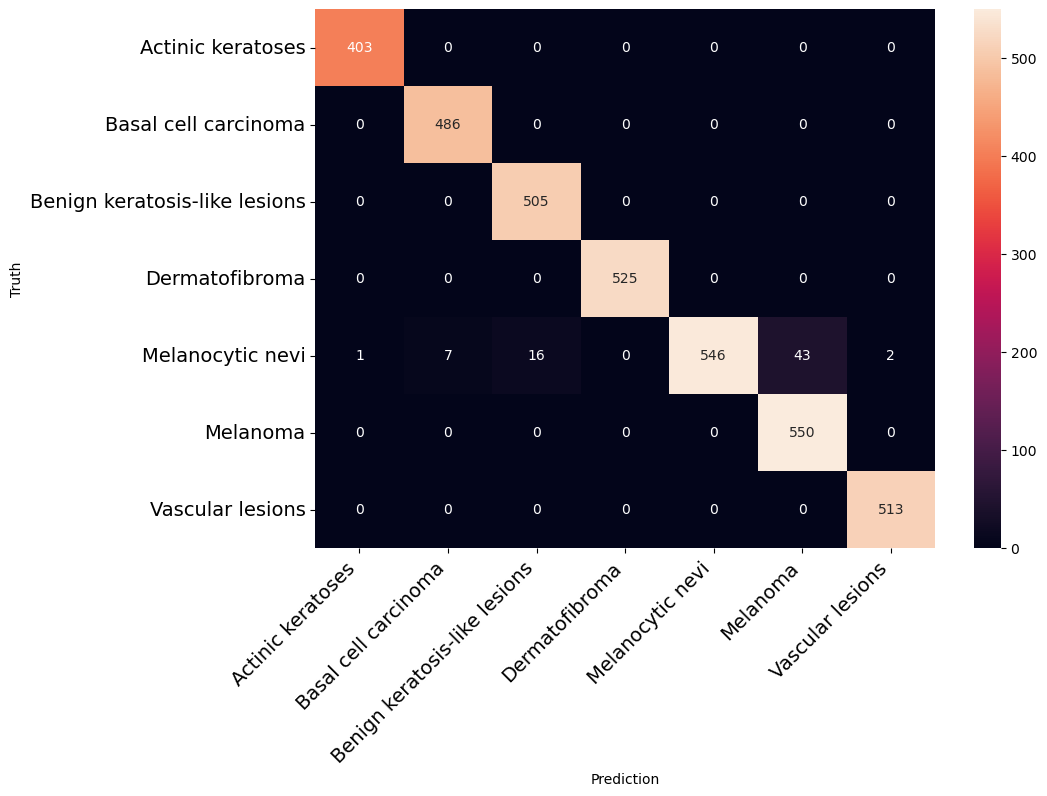

In [81]:
cm = confusion_matrix(np.argmax(y_test,1),prediction_labels)
print_confusion_matrix(cm,class_names=['Actinic keratoses',
                                       'Basal cell carcinoma',
                                       'Benign keratosis-like lesions',
                                       'Dermatofibroma',
                                       'Melanocytic nevi',
                                       'Melanoma',
                                       'Vascular lesions'])

In [82]:
model.save("skin_disease_classification.h5")

## <em>Partie 3: Pipeline (Segmentation + Classification)<em>

In [83]:
images, labels = create_dataset(df_test)

In [90]:
def predict(image):
    mask = model_1.predict(image.reshape(1,224,224,3),verbose=0)
    mask = enhance(mask)
    mask = np.concatenate((mask, mask, mask),axis=2)
    pred = model.predict(mask.reshape(1,224,224,3),verbose=0)
    pred = np.argmax(pred, 1)[0]
    return pred

In [91]:
preds = []

for image in images:
    preds.append(predict(image))

preds = np.array(preds)

## <em>Partie 4: Analyse des résultats<em>

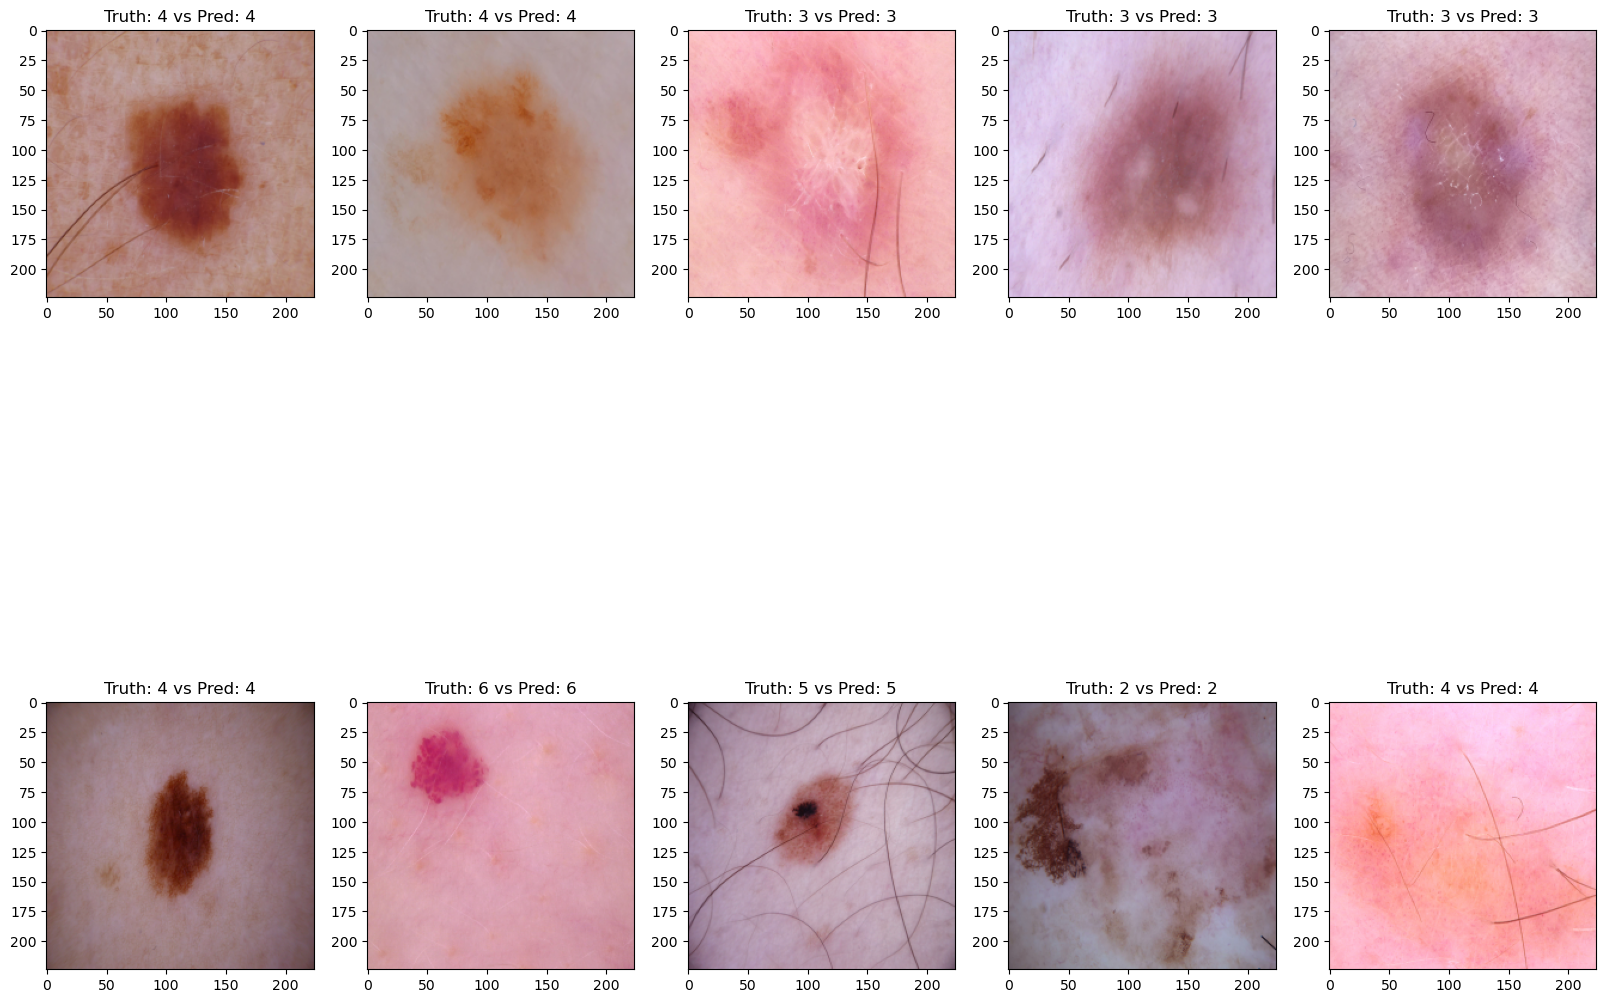

In [92]:
fig, axes = plt.subplots(2, 5, figsize=(20,16))
for j in range(5):
    axes[0,j].imshow(images[j+10])
    axes[1,j].imshow(images[j+15], cmap="gray")
    axes[0,j].set_title(f"Truth: {labels[j+10]} vs Pred: {preds[j+10]}")
    axes[1,j].set_title(f"Truth: {labels[j+15]} vs Pred: {preds[j+15]}")
plt.show()

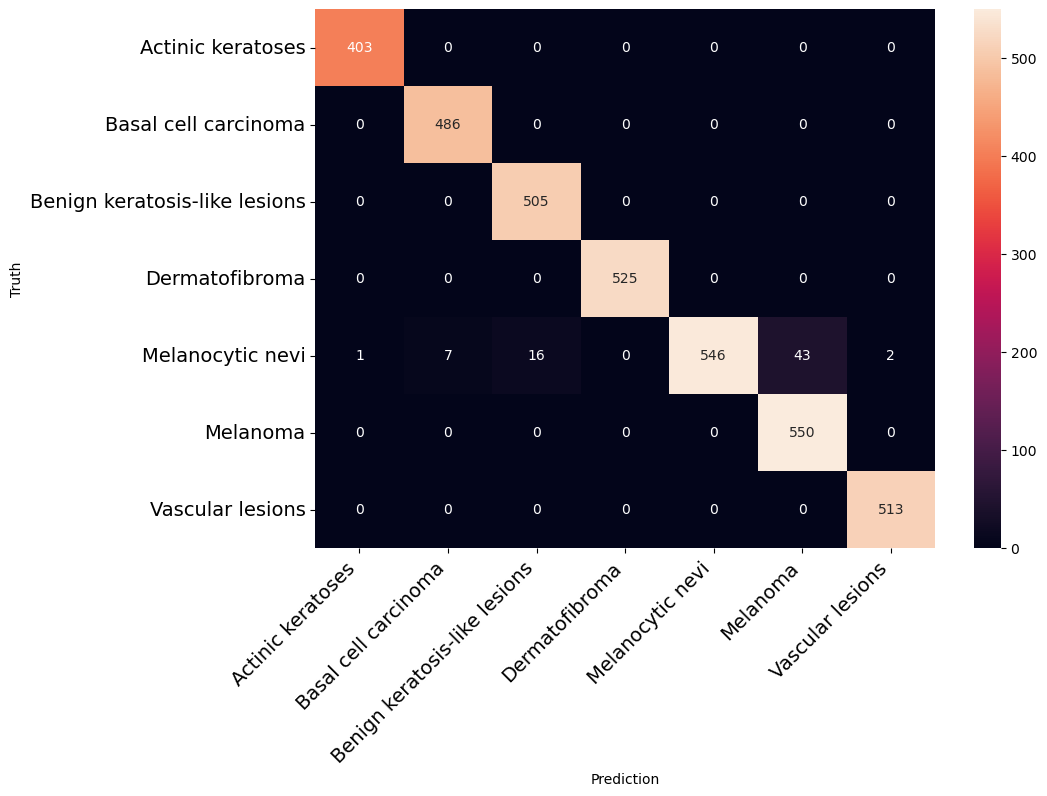

In [93]:
cm = confusion_matrix(labels,preds)
print_confusion_matrix(cm,class_names=['Actinic keratoses',
                                       'Basal cell carcinoma',
                                       'Benign keratosis-like lesions',
                                       'Dermatofibroma',
                                       'Melanocytic nevi',
                                       'Melanoma',
                                       'Vascular lesions'])

In [96]:
print(classification_report(labels,preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       403
           1       0.99      1.00      0.99       486
           2       0.97      1.00      0.98       505
           3       1.00      1.00      1.00       525
           4       1.00      0.89      0.94       615
           5       0.93      1.00      0.96       550
           6       1.00      1.00      1.00       513

    accuracy                           0.98      3597
   macro avg       0.98      0.98      0.98      3597
weighted avg       0.98      0.98      0.98      3597

